# Cluster Analysis: Poetic Features

This notebook contains the reproduction data for SS. 6.3 'Cluster Analysis' and 6.4 'Searching for a Temporal Signal'.

In [1]:
from mqdq import babble, elegy

import numpy as np
import pandas as pd
import scipy as sp

import glob
import umap
import math

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs('ovid/OV-epis.xml', name="Ep.")
for b in ep:
    b.author = 'Ovid'
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-tri*.xml')), name="Tr.")
for b in tr:
    b.author = 'Ovid'
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-amo*.xml')), name="Am.")
for b in am:
    b.author = 'Ovid'
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob('TIB-ele*.xml')), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = 'Tibullus'
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob('PROP-ele*.xml')), name="Prop.")
for b in prop:
    b.author = 'Propertius'
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs('CATVLL-carm.xml', name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = 'Catullus'
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-pon*.xml')), name="Pont.")
for b in pon:
    b.author = 'Ovid'
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)


In [4]:
trim = [x for x in collection if x.elegiac and len(x) > 20]
# This method does the heavy lifting. It measures the 43 poetic features
# and converts each poem into an observation vector.
vecs_trim = elegy.vectorise_babs(trim)

In [77]:
vecs_trim.head()

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.0,0.094828,4.393948,0.739842,116,0.0
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.0,0.114865,4.071062,1.027448,148,0.0
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.0,0.090909,3.845700,0.484285,154,0.0
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.0,0.073864,3.822098,0.893575,176,0.0
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.0,0.056962,3.727347,0.713715,158,0.0


In [5]:
%load_ext rpy2.ipython

# Projection Methods

These are Figs 7(b) and 7(c). Both UMAP and t-SNE attempt to produce a 2D figure in which the local manifold properties of the high dimensional space is preserved. In other words, points that are _locally_ 'near' in the original feature space (43 dimensions) should end up locally 'near' in the projection, however the overall topology is somewhat arbitrary; points should cluster correctly, but the distribution of the clusters across the 2D figure may not reflect the true inter-cluster distances. UMAP more or less 'just works' while t-SNE has a `perplexity` parameter which affects the tightness of the clusters (sometimes it is described as broadly analagous to the _k_ in _k_ nearest neighbours.

Neither of these projections produce a result where distances are easy to understand statistically, and so they are qualitative methods (no _P_-values here!).

In [74]:
# Do the actual UMAP projection.

umap_results = pd.DataFrame(vecs_trim[['Poem','Work','Author']])
umapper = umap.UMAP(
    n_neighbors=15,
    # project to 2 dimensions
    n_components=2,
    metric='euclidean',
    # UMAP figures change with every run if not seeded
    random_state=42
)

scaled = StandardScaler().fit_transform(vecs_trim[vecs_trim.columns[3:]])
u = umapper.fit_transform(scaled)
umap_results['X'], umap_results['Y'] =  u[:,0], u[:,1]


In [75]:
umap_results

,Poem,Work,Author,X,Y
0,Ep. 1,Ep.,Ovid,10.869323,3.277632
1,Ep. 2,Ep.,Ovid,10.707171,2.364203
2,Ep. 3,Ep.,Ovid,11.384416,3.001867
3,Ep. 4,Ep.,Ovid,11.116519,3.265265
4,Ep. 5,Ep.,Ovid,11.330111,2.362623
...,...,...,...,...,...
261,Pont. 4 12,Pont.,Ovid,9.899364,1.411422
262,Pont. 4 13,Pont.,Ovid,8.322745,3.102836
263,Pont. 4 14,Pont.,Ovid,8.398219,1.677492
264,Pont. 4 15,Pont.,Ovid,9.621218,1.737126


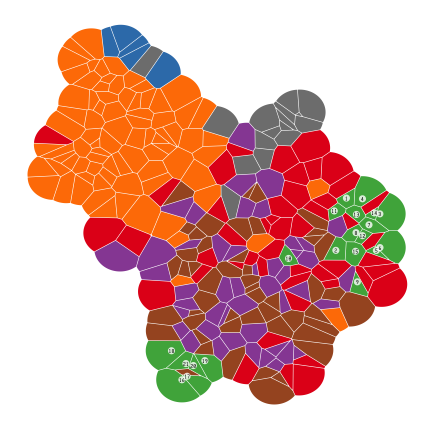

In [76]:
%%capture --no-display
%%R -i umap_results -h 6 -w 6 -u in -r 72

# These libraries will stay active for future %%R cells
# BUT if you run them out of order things will break

library(ggforce)
library(ggsci)
library(extrafont)
library(dplyr)
library(stringr)

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", 'grey50', "#A65628")

# data just for numbering the Heroides points
epu <- umap_results %>% 
    filter(Work=='Ep.') %>%
    mutate(Num = str_extract(Poem, "[0-9]+"))
    
ggplot(data=umap_results,aes(x=X, y=Y)) +
# Plot everything as a Voronoi tesselation 
geom_voronoi_tile(
    aes(fill = Work, group = -1L, ),
    max.radius = 0.4,
    expand = unit(-0.1, 'mm'), 
    radius = unit(0.1, 'mm')
) +
scale_fill_manual(values=pal) +
# Colours for the voronoi
geom_point(data=epu,color='white',alpha=0.8, size=3,shape=16) +
# For Heroides, add a numbered white dot
geom_text(data=epu,aes(label=Num),family='Envy Code R',size=2)+

theme_minimal() +

theme(
    panel.border = element_blank(),
    # No legend for the t-SNE and UMAP plots, since they will be
    # on the same page as the large kNN plot
    legend.position='none',
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    text = element_text(size=30, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank()
)

# fn <- "/Users/ben/silius/ep15/ele_metre_umap.pdf"
# ggsave(fn, dpi=600, height=6, width=6)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

In [9]:
# recommended t-SNE perplexity (according to some) is sqrt(observations).

# The clusters are tighter as we increase the perplexity.

math.sqrt(vecs_trim.shape[0])

16.30950643030009

In [32]:
# Do t-SNE

tsne_results = pd.DataFrame(vecs_trim[['Poem','Work','Author']])

# Some features (like poem length in lines) are orders of magnitude 
# larger than others (most are proportions in [0,1]), so we need to
# scale the features to make it easier for the clustering algorithms.
#
# StandardScaler scales to a zero mean and unit variance.

scaled = StandardScaler().fit_transform(vecs_trim[vecs_trim.columns[3:]])

t = TSNE(n_components=2, perplexity=16.31, n_iter=5000, random_state=42).fit_transform(scaled)
tsne_results['X'], tsne_results['Y'] =  t[:,0], t[:,1]

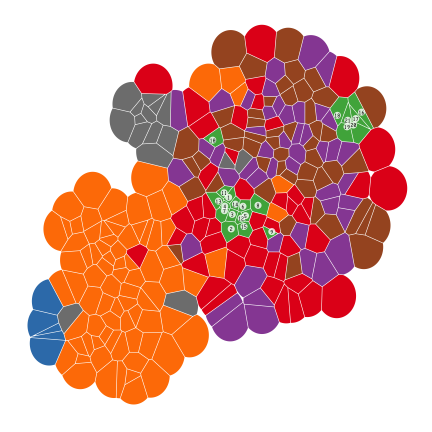

In [35]:
%%capture --no-display
%%R -i tsne_results -h 6 -w 6 -u in -r 72

# libraries only need to be loaded once

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", 'grey50', "#A65628")

# data just for numbering the Heroides points
ept <- tsne_results %>% 
    filter(Work=='Ep.') %>%
    mutate(Num = str_extract(Poem, "[0-9]+"))
    
ggplot(data=tsne_results,aes(x=X, y=Y)) +
# Plot everything as a Voronoi tesselation 
geom_voronoi_tile(
    aes(fill = Work, group = -1L, ),
    max.radius = 2.5,
    expand = unit(-0.1, 'mm'), 
    radius = unit(0.1, 'mm')
) +
# Colours for the voronoi
scale_fill_manual(values=pal) +
# For Heroides, add a numbered white dot
geom_point(data=ept,color='white',alpha=0.8, size=3,shape=16) +
geom_text(data=ept,aes(label=Num),family='Envy Code R',size=2)+

theme_minimal() +

theme(
    panel.border = element_blank(),
    # No legend for the t-SNE and UMAP plots, since they will be
    # on the same page as the large kNN plot
    legend.position='none',
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    text = element_text(size=30, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank()
)

# fn <- "/Users/ben/silius/ep15/ele_metre_tsne.pdf"
# ggsave(fn, dpi=600, height=6, width=6)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

# Bootstrap Consensus Tree

For the idea, see Maciej Eder, (2017) Visualization in stylometry: Cluster analysis using networks, Digital Scholarship in the Humanities, 32 (1), Pages 50–64, https://doi.org/10.1093/llc/fqv061, and see also the implementation in R Stylo. The previous visualisations project from high dimensional _position_ to 2D. This method constructs many kNN trees from feature subsets, with each tree giving the closest three nodes artificial weights (3, 2, 1). The trees are then aggregated, with the idea that neighbours that are truly related will be close in many of the subset feature universes. The final layout is artificial. Users of `stylo` tend to use Gephi and ForceAtlas2, but in this case I use Fruchterman-Reingold (more or less the same idea) which can be easily done in R with `ggraph`. Once the consensus tree is trimmed, it could be laid out with many different algorithms, and the results are broadly similar (the point positions may change slightly but the overall topological implications don't vary). The advantage of this BCT method is that is shows the strength of the relationships as well as the determined positions.


In [12]:
X,y = vecs_trim[vecs_trim.columns[3:]], vecs_trim['Poem']

In [13]:
dfs = []
rng = np.random.RandomState(seed=42)
for _ in range(500):
    this_X = X.sample(15,axis=1,random_state=rng)
    scaled = StandardScaler().fit_transform(this_X)
    #cl = KNeighborsClassifier(n_neighbors=5, metric='mahalanobis',metric_params={'V': np.cov(scaled.T)})
    cl = KNeighborsClassifier(n_neighbors=3, metric='cosine')
    cl.fit(scaled,y)
    dists,indices = cl.kneighbors(n_neighbors=8)
    dicts = []
    for i, node_ary in enumerate(indices):
        for j, node in enumerate(node_ary):
            dicts.append({
                'from': y[i],
                'to': y[node],
                # neighbors are sorted low distance to high
                # so this gives us the 'inverse rank' ie lowest
                # distance of n neighbors scores n, next is n-1 etc
                # this is consistent with the stylo BCT algorithm
                'weight': (len(node_ary)-j)
            })
    dfs.append(pd.DataFrame(dicts))

graph = pd.concat(dfs).groupby(['from','to'],as_index=False).agg(sum)

In [65]:
# The difference between the two filtering methods:
# - filtering here means only the top 20% of edges are used in the FR layout calculation
# - filtering in the ggplot (below) means some of the remaining edges (there are still MANY) are not drawn
#   but they _are_ used when laying out the points.

graph_trim=graph.nlargest(int(len(graph)*0.2),'weight')

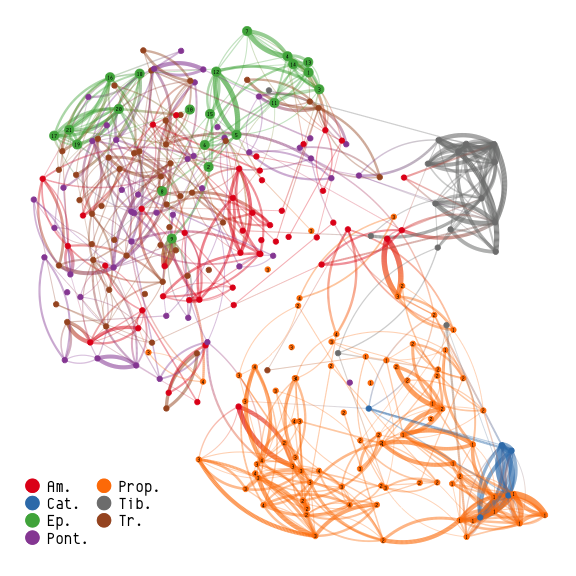

In [70]:
%%capture --no-display
%%R -i graph_trim  -h 8 -w 8 -u in -r 72

# other libraries only need to be loaded once
library(ggraph)
library(tidygraph)

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "grey50", "#A65628")

set.seed(42)

as_tbl_graph(graph_trim) %>%
    # Add a node attribute called 'work' which is the poem name with
    # no numbers eg Pont. 3 4 -> Pont.
    activate(nodes) %>%
    mutate(work = str_replace_all(name, '\\s[0-9]+', '')) %>%
    # Layout with Fruchterman Reingold
    ggraph(layout = 'fr') +
    # fan2 does curved lines when nodes are linked in both directions
    # and also lets you interpolate colour along the edge
    geom_edge_fan2(
        aes(
            filter=weight>=900,
            width=weight,
            color=node.work,
            alpha=weight
        ),
        strength=2,
        show.legend=FALSE
    ) +
    # Normal nodes
    geom_node_point(size = 2.2, aes(color = work), alpha=1) +
    # Heroides nodes over the top and bigger
    geom_node_point(aes(filter=work=='Ep.',color=work),size=4) +
    # Number Heroides and Propertius with the first number that
    # follows the name. For Prop. this is the book number, for Ep.
    # it is the letter number (it's not divided into books)
    geom_node_text(
        size = 2,
        family="Envy Code R",
        aes(
            filter=work %in% c('Ep.', 'Prop.'),
            label=str_extract(name,'\\d+')
        )
    ) +
    
    # Colours and widths and alpha fine tuning
    scale_fill_manual(values=pal) +
    scale_color_manual(values=pal) +
    scale_edge_color_manual(values=pal) +
    scale_edge_width(range=c(0.4,3)) +
    scale_edge_alpha(range=c(0.3,1)) +
    
    theme_bw() +
    guides(
        color = guide_legend(
            ncol=2,
            override.aes=aes(label="",size=6)
        )
    ) +
    
    theme(
        plot.title = element_text(margin = margin(b = 50)),
        panel.border = element_blank(),
        legend.title=element_blank(),
        legend.position= c(0.15, 0.1),
        legend.text=element_text(size=16),
        legend.spacing.x = unit(2, 'mm'),
        legend.spacing.y = unit(0.1, 'mm'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text = element_text(family="Envy Code R"),
        panel.grid.minor=element_blank(), 
        panel.grid.major=element_blank()
    )

# fn <- "/Users/ben/silius/ep15/ele_metre_bct.pdf"
# ggsave(fn, dpi=600, height=8, width=8)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

# Searching for a Temporal Signal

The final idea builds on what appears to be a fairly clean temporal signal in the BCT data - in both Propertius (who wrote four books spanning a fair length of time) and Ovid we seem to see a stylistic separation between early and late works. Based on that, and given that we know that the _Amores_ are early works (with some reservations, see the paper) and that _Ex Ponto_ is probably his latest collection, we can try to determine, for each work in the _Heroides_, whether it is stylistically more similar to one or other other, and hence more likely to be early or late.

This is done using two methods (for the sake of comparison). The most obvious is to use `NearestCentoid` and simply look at the relative difference - is the _Heroides_ point closer to the class centroid of _Amores_ or _Ex Ponto_? However, the space is not topologically well behaved, and the class clusters are different sizes and shapes, so it is not certain that centroid distance is ideal - think of something like taking the relative distance to the capital of a neighbouring country versus taking the distance to the closest border - the results could be very different. So, the second method uses the `SVM` "decision function" which is something like a relative probability. Intuitively, this is the equivalent of asking the algorithm "If you couldn't classify this as _Heroides_, what would be your next guess?".

In [55]:
svmn = lambda: make_pipeline(
    StandardScaler(),
    SVC(gamma='scale', kernel='rbf', C=128, decision_function_shape='ovr')
)

In [17]:
X = vecs_trim.drop(['Author', 'Work', 'Poem'],axis=1)
y = vecs_trim.Work

In [56]:
clf = svmn()
clf.fit(X,y)
y_pred = clf.predict(X) # this is, obviously, just y

# The decision function is a little opaque.
# In the one-versus-rest strategy it's mostly a voting game
# where a candidate class is compared against each of the other 
# possible classes, so eg consider AB AC AD AE, and if the point is on
# The A side of the hyperplane it gets a positive vote. Finally
# the class with the most votes wins, BUT there is a transformation
# of those voting scores to turn it into a continuous function for the
# purpose of tiebreaks. Long story short, the scores are kind of
# like relative likelihoods, biggest number wins. (they're not 
# straight up probabilities because they can be negative, they're
# more like an exponential parameter for a probability density 
# function)
#
# The NearestCentroid method is much more transparent.

y_dec = clf.decision_function(X)

In [57]:
# Creates a tuple of (poem, work, {decision function per class})
names = sorted(y.unique())
z = [dict(zip(names,x)) for x in y_dec]
conf_scores = [x for x in list(zip(vecs_trim.Poem, y_pred, z))]
conf_scores[:3]

[('Ep. 1',
  'Ep.',
  {'Am.': 5.280961444416006,
   'Cat.': -0.28911033352645477,
   'Ep.': 6.285716536747338,
   'Pont.': 2.860953182372151,
   'Prop.': 1.7579107889168084,
   'Tib.': 0.7583967543526808,
   'Tr.': 4.180092085343919}),
 ('Ep. 2',
  'Ep.',
  {'Am.': 4.228479085973843,
   'Cat.': -0.2872691562477925,
   'Ep.': 6.285710424361205,
   'Pont.': 2.8168493990626033,
   'Prop.': 1.751880053321003,
   'Tib.': 0.7522768941658423,
   'Tr.': 5.278533244809373}),
 ('Ep. 3',
  'Ep.',
  {'Am.': 5.2589552361768925,
   'Cat.': -0.2870933654715619,
   'Ep.': 6.285723478619945,
   'Pont.': 2.861164377326509,
   'Prop.': 0.767040598073611,
   'Tib.': 1.8801247141923725,
   'Tr.': 4.081215266263273})]

In [58]:
conf_scores_ep = [x for x in conf_scores if x[0].startswith('Ep.')]

In [59]:
# Build a dataframe of the signed difference between distance to Pont
# and distance to Am, to see which work each Ep is more similar to.

dd = []
for x in conf_scores_ep:
    this = {
        'Work1':int(x[0].split(' ')[-1]),
        'Diff':x[2]['Pont.']-x[2]['Am.'],
    }
    if this['Diff'] <= 0:
        this['Sign'] = 'lt'
    else:
        this['Sign'] = 'gt'
    dd.append(this)
df_ep_svm = pd.DataFrame(dd)

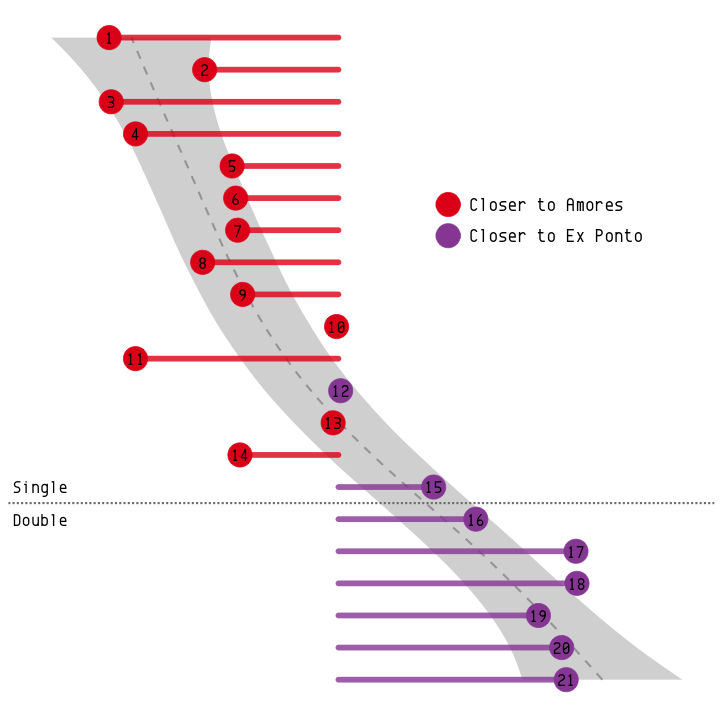

In [69]:
%%capture --no-display
%%R -i df_ep_svm -h 10 -w 10 -u in -r 72

# libraries only need to be loaded once

ggplot(df_ep_svm, aes(x=Work1, y=Diff)) +
# GAM trendline
geom_smooth(method='gam',show.legend=F,fill='grey60',color='grey65',linetype='dashed') +
# Stems of the lollipops
geom_segment(
    aes(y = 0, 
        x = `Work1`, 
        yend = Diff, 
        xend = `Work1`,
        color = Sign
       ), 
    size=2.7,
    alpha=0.8,
    lineend='round'
) +
# Heads of the lollipops
geom_point(stat='identity', aes(color=Sign,label=Work1), size=11)  +
geom_text(color="black", label=df_ep_svm$Work1, size=6, family="Envy Code R", face='bold') +
# Colours and legend
scale_color_manual( 
    labels = c( "Closer to Ex Ponto", "Closer to Amores"), 
    values = c("lt"="#E41A1C", "gt"="#984EA3"),
    guide=guide_legend(reverse=TRUE)
) +
# Line between Singles and Doubles
geom_vline(xintercept = 15.5, color='grey50', lty='11', size=1) +
annotate("text", x = 15, y = min(df_ep_svm$Diff)*1.3, size=6, family='Envy Code R',face='bold',label = "Single") +
annotate("text", x = 16, y = min(df_ep_svm$Diff)*1.3, size=6, family='Envy Code R',face='bold',label = "Double") +

# Lollipops go sideways
coord_flip() +
theme_minimal() +
# put 1 at the top
scale_x_reverse(breaks = seq(1,21,1)) +

theme(
    panel.border=element_blank(),
    legend.title=element_blank(),
    legend.position= c(0.75, 0.7),
    legend.text=element_text(size=18),
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    panel.grid.minor=element_blank(), 
    panel.grid.major=element_blank(),
    text=element_text(family="Envy Code R"),
)

# fn <- "/Users/ben/silius/ep15/ampont_svm.pdf"
# ggsave(fn, dpi=600, height=10, width=10)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))

In [23]:
# building the Pipeline this way lets you access individual steps by key

steps = [('ss',StandardScaler()), ('nc',NearestCentroid())]
p = Pipeline(steps)

In [24]:
p.fit(X,y)

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('nc',
                 NearestCentroid(metric='euclidean', shrink_threshold=None))],
         verbose=False)

In [25]:
centroids = dict(zip(p['nc'].classes_,p['nc'].centroids_))

In [26]:
# Add column for each poem showing distance from each Work centroid

# Note, eg, that Ep 1 is only barely closer to the Heroides (Ep)
# centroid than to Amores (Am).

df = vecs_trim[['Author','Work','Poem']].copy()
for klass, cent in centroids.items():
    # returns a vector which contains the distance of this centroid
    # from each row (one row is one poem)
    df[klass] = pairwise_distances(p['ss'].transform(X), cent.reshape(1,-1), metric='euclidean')
df

,Author,Work,Poem,Am.,Cat.,Ep.,Pont.,Prop.,Tib.,Tr.
0,Ovid,Ep.,Ep. 1,3.671085,11.190352,3.652853,4.569759,5.887874,5.473217,4.393568
1,Ovid,Ep.,Ep. 2,4.199680,11.747202,3.624803,4.665401,5.735074,6.953796,4.150896
2,Ovid,Ep.,Ep. 3,4.139405,11.297278,3.464566,4.720519,5.766121,5.996971,4.779754
3,Ovid,Ep.,Ep. 4,3.686598,11.511127,2.673446,4.183307,5.969024,5.459273,3.998467
4,Ovid,Ep.,Ep. 5,3.453231,11.563856,2.713753,3.872073,5.108264,6.987492,3.760567
...,...,...,...,...,...,...,...,...,...,...
261,Ovid,Pont.,Pont. 4 12,6.200536,11.641769,6.374451,5.767334,7.703410,9.568786,5.838861
262,Ovid,Pont.,Pont. 4 13,6.566550,10.748007,7.151845,6.448014,5.902347,7.694844,6.436666
263,Ovid,Pont.,Pont. 4 14,6.086557,10.975621,6.203513,5.239586,6.028175,7.179687,5.539768
264,Ovid,Pont.,Pont. 4 15,6.866808,11.038775,7.040607,6.434754,7.696926,7.639617,6.724954


In [78]:
# Add the calculated columns that will be used in the plot

df['AmPont'] = df['Am.'] - df['Pont.']
df['Sign'] = df.apply(lambda r: 'lt' if r['AmPont'] < 0 else 'gt', axis=1)
df['Num'] = df.apply(lambda r: int(r['Poem'].split(' ')[-1]),axis=1)
# Subset just the Heroides
df_ep = df[df.Work=='Ep.']
df_ep

,Author,Work,Poem,Am.,Cat.,Ep.,Pont.,Prop.,Tib.,Tr.,AmPont,Sign,Num
0,Ovid,Ep.,Ep. 1,3.671085,11.190352,3.652853,4.569759,5.887874,5.473217,4.393568,-0.898674,lt,1
1,Ovid,Ep.,Ep. 2,4.199680,11.747202,3.624803,4.665401,5.735074,6.953796,4.150896,-0.465721,lt,2
2,Ovid,Ep.,Ep. 3,4.139405,11.297278,3.464566,4.720519,5.766121,5.996971,4.779754,-0.581115,lt,3
3,Ovid,Ep.,Ep. 4,3.686598,11.511127,2.673446,4.183307,5.969024,5.459273,3.998467,-0.496709,lt,4
4,Ovid,Ep.,Ep. 5,3.453231,11.563856,2.713753,3.872073,5.108264,6.987492,3.760567,-0.418842,lt,5
5,Ovid,Ep.,Ep. 6,4.000040,12.088034,3.206703,4.239816,5.964528,6.612607,4.355806,-0.239777,lt,6
6,Ovid,Ep.,Ep. 7,3.901850,10.985673,2.741975,4.218276,5.949802,5.873655,4.340154,-0.316426,lt,7
7,Ovid,Ep.,Ep. 8,3.689558,11.374886,3.726015,4.567939,5.583116,7.253546,4.297026,-0.878380,lt,8
8,Ovid,Ep.,Ep. 9,4.603945,11.294365,4.473633,5.112382,6.557737,8.251699,5.057970,-0.508437,lt,9
9,Ovid,Ep.,Ep. 10,3.694038,10.569619,3.134340,3.810421,5.236129,6.392191,3.773067,-0.116384,lt,10


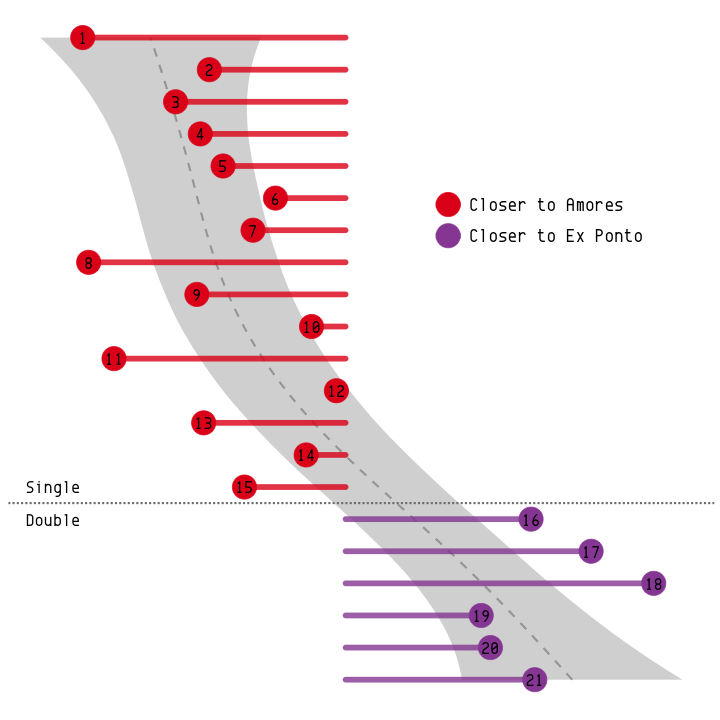

In [31]:
%%capture --no-display
%%R -i df_ep -h 10 -w 10 -u in -r 72

# libraries only need to be loaded once

ggplot(df_ep, aes(x=Num, y=AmPont)) +
# GAM trendline
geom_smooth(method='gam',show.legend=F,fill='grey60',color='grey65',linetype='dashed') +
# Stems of the lollipops
geom_segment(
    aes(
        y = 0, 
        x = `Num`, 
        yend = AmPont, 
        xend = `Num`,
        color = Sign
    ), 
    size=2.7,
    alpha=0.8,
    lineend='round'
) +
# Heads of the lollipops
geom_point(stat='identity', aes(color=Sign,label=Num), size=11)  +
geom_text(color="black", label=df_ep$Num, size=6, family="Envy Code R", face='bold') +
# Colours and legend
scale_color_manual( 
    labels = c( "Closer to Ex Ponto", "Closer to Amores"), 
    values = c("lt"="#E41A1C", "gt"="#984EA3"),
    guide=guide_legend(reverse=TRUE)
) +
# Line between Singles and Doubles
geom_vline(xintercept = 15.5, color='grey50', lty='11', size=1) +
annotate("text", x = 15, y = -1, size=6, family='Envy Code R',face='bold',label = "Single") +
annotate("text", x = 16, y = -1, size=6, family='Envy Code R',face='bold',label = "Double") +

# Lollipops go sideways
coord_flip() +
theme_minimal() +
scale_x_reverse(breaks = seq(1,21,1)) +

theme(
    panel.border=element_blank(),
    legend.title=element_blank(),
    legend.position= c(0.75, 0.7),
    legend.text=element_text(size=18),
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    panel.grid.minor=element_blank(), 
    panel.grid.major=element_blank(),
    text=element_text(family="Envy Code R"),
)

# fn <- "/Users/ben/silius/ep15/ampont_nc.pdf"
# ggsave(fn, dpi=600, height=10, width=10)
# embed_fonts(fn)
# system(sprintf("pdfcrop %s", fn))